In [1]:
!pip install opendatasets
import opendatasets as od

import numpy as np
import pandas as pd 
import cv2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
import os

In [2]:
#Variables preparation

image_size= 100

od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: peihanl
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:14<00:00, 165MB/s]


In [6]:
dir_base='/content/chest-xray-pneumonia/chest_xray'
test_dir = '{}/{}'.format(dir_base, 'test')
train_dir = '{}/{}'.format(dir_base, 'train')
val_dir = '{}/{}'.format(dir_base, 'val')

test_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'test','NORMAL')
train_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'train','NORMAL')
val_dir_normal_cases = '{}/{}/{}'.format(dir_base, 'val','NORMAL')

test_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'test','PNEUMONIA')
train_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'train','PNEUMONIA')
val_dir_pneumonia_cases = '{}/{}/{}'.format(dir_base, 'val','PNEUMONIA')

In [7]:
# Define helper function
def get_data(path,label,data_type,process_flipped):
    result = []
    items = os.listdir(path)
    for i in items:
        img_path = '{}/{}/{}/{}'.format(dir_base,data_type,label,i)
        result.append((get_image_arr(img_path),label))
        if process_flipped == True:
            result.append((get_flipped_image_arr(img_path),label))
    return pd.DataFrame(result, columns=['image', 'label'],index=None)

def get_flipped_image_arr(path):
        original = cv2.imread(path) 
        img = cv2.flip(original, 1)
        img = cv2.resize(img, (image_size, image_size),interpolation = cv2.INTER_AREA).reshape(1,-1)
        return img
    
def get_image_arr(path):
        img = cv2.imread(path) 
        img = cv2.resize(img, (image_size, image_size),interpolation = cv2.INTER_AREA).reshape(1,-1)
        return img
    
def show_plot(k_values,accuracy_values):
    fig = plt.figure()
    fig.subplots_adjust(top=0.8)
    ax1 = fig.add_subplot()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('K value')
    plt.plot(k_values,accuracy_values,label='Accuracy for k params')
    plt.scatter(k_values,accuracy_values,c=k_values,alpha=1)
    plt.legend()
    plt.show()

def show_confusion_matrix(model,x,y):
    disp = plot_confusion_matrix(model, x, y,
                             normalize=None)
    plt.show()

In [8]:
data_normal = get_data(train_dir_normal_cases,'NORMAL','train',True)
data_pneumonia = get_data(train_dir_pneumonia_cases,'PNEUMONIA','train',False)

In [9]:
data = pd.concat([data_normal,data_pneumonia])
images = data.image
y = data.label

X = []
for i in images.values:
    X.append(i[0])
X = np.array(X)

In [10]:
print('X shape:',X.shape)
print('Y shape:',y.shape)

X shape: (6557, 30000)
Y shape: (6557,)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.85, random_state=42)

Accuracy for k=1: 0.8995335486185863


              precision    recall  f1-score   support

      NORMAL       0.93      0.82      0.87      2321
   PNEUMONIA       0.88      0.96      0.92      3253

    accuracy                           0.90      5574
   macro avg       0.91      0.89      0.89      5574
weighted avg       0.90      0.90      0.90      5574



Accuracy for k=3: 0.9122712594187298


              precision    recall  f1-score   support

      NORMAL       0.95      0.83      0.89      2321
   PNEUMONIA       0.89      0.97      0.93      3253

    accuracy                           0.91      5574
   macro avg       0.92      0.90      0.91      5574
weighted avg       0.92      0.91      0.91      5574



Accuracy for k=5: 0.9153211338356656


              precision    recall  f1-score   support

      NORMAL       0.96      0.83      0.89      2321
   PNEUMONIA       0.89      0.97      0.93      3253

    accuracy                           0.92      5574
   macr

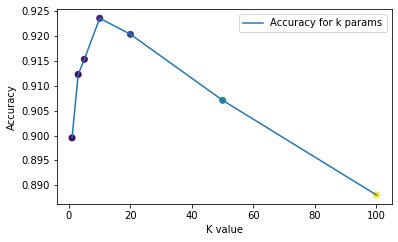

In [12]:
k_values = [1, 3, 5, 10, 20, 50, 100]
accuracy_values = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    predictions = model.predict(X_val)
    acc = metrics.accuracy_score(y_val, predictions)
    accuracy_values.append(acc)
    print('Accuracy for k={}:'.format(str(k)),acc)
    print('\n')
    print(classification_report(y_val, predictions))
    print('=========================================================')
    print('\n')
show_plot(k_values,accuracy_values)

From the plot above, we can see that when k = 10, the accuracy is highest, so we choose k = 10.

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X,y)

KNeighborsClassifier(n_neighbors=10)

In [14]:
#Load test data
test_data_normal = get_data(test_dir_normal_cases,'NORMAL','test',False)
test_data_pneumonia = get_data(test_dir_pneumonia_cases,'PNEUMONIA','test',False)

test_data_total = pd.concat([test_data_normal,test_data_pneumonia])

y_test_data = test_data_total.label

X_test_data = []
for i in test_data_total.image.values:
    X_test_data.append(i[0])
    
X_test_data = np.array(X_test_data)

In [22]:
predictions_test = knn_model.predict(X_test_data)
acc_test = metrics.accuracy_score(y_test_data, predictions_test)
print('Accuracy for test',acc_test)
print(classification_report(y_test_data, predictions_test))
# show_confusion_matrix(knn_model,X_test_data,y_test_data)

Accuracy for test 0.7660256410256411
              precision    recall  f1-score   support

      NORMAL       0.96      0.39      0.56       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624



In [23]:
print(classification_report(y_test_data, predictions_test))

              precision    recall  f1-score   support

      NORMAL       0.96      0.39      0.56       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624



In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_data, predictions_test))

In [25]:
import seaborn as sns

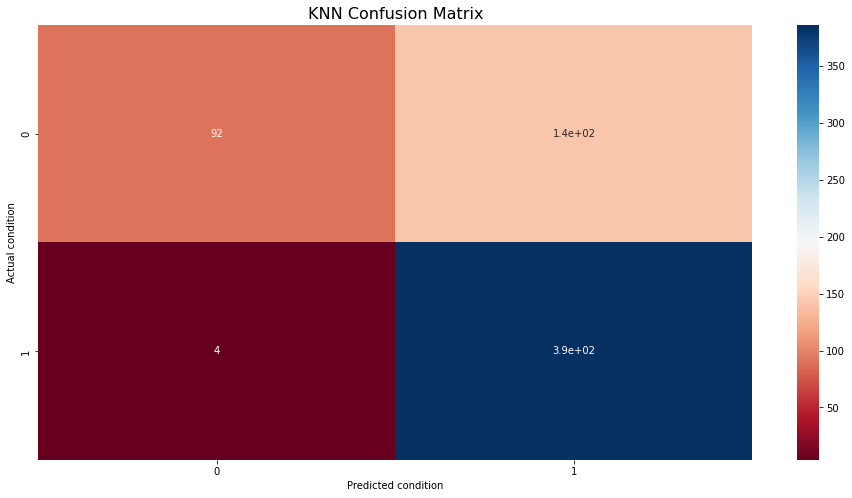

In [26]:
plt.figure(figsize=(16,8))
sns.heatmap(confusion_matrix_df, cmap="RdBu", annot=True)
plt.title('KNN Confusion Matrix', fontsize=16)
plt.xlabel("Predicted condition")
plt.ylabel("Actual condition")
plt.savefig("knn_confusion_matrix.png")
plt.show()